## esegui all'inizio

In [1]:
import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
#import pymrmr
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc




# Percorso del file HDF5 da cui caricare i dati
load_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/classificator_data.h5"
#load_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\classificator_data.h5"

# Inizializza le liste per contenere i dati
loaded_class_images = []
loaded_class_labels = None
loaded_patients = None

# Apre il file HDF5 in modalità lettura
with h5py.File(load_path, 'r') as hf:
    # Itera su tutti i gruppi nel file HDF5
    for group_name in hf.keys():
        # Controlla se il nome del gruppo inizia con "patient_"
        if group_name.startswith("patient_"):
            group = hf[group_name]
            # Carica le immagini dal dataset 'images' all'interno del gruppo
            loaded_class_images.append(np.array(group['images']))
        elif group_name == "labels":
            # Carica le etichette dal dataset 'labels'
            loaded_class_labels = hf['labels'][:]
        elif group_name == "patients":
            # Carica i numeri dei pazienti dal dataset 'patients'
            loaded_patients = hf['patients'][:]

print(f"Dati caricati da {load_path}")
print(f"Numero di pazienti: {len(loaded_class_images)}")
print(f"Esempio di immagini per paziente: {loaded_class_images[0].shape}")


# Carica il file CSV
file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/data_rad_clin_DEF.csv"
#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\data_rad_clin_DEF.csv"
data = pd.read_csv(file_path)

# Lista degli ID da escludere
ids_to_exclude = ["patient_TC_19", "patient_TC_40", "patient_TC_88", "patient_TC_150", "patient_TC_193"]

# Filtra il DataFrame per escludere le righe con gli ID specificati
filtered_data = data[~data['IDs_new'].isin(ids_to_exclude)]

# Estrae i valori dalla colonna 'label' del DataFrame filtrato
labels_column = filtered_data['label']

# Converte i valori della colonna 'label' in numeri interi
labels = labels_column.astype(int).tolist()

labels=np.array(labels)
print("Labels:", labels)
print("Number of labels:", len(labels))


# Carica il modello encoder
encoder = load_model("/Users/alessiamenozzi/Desktop/ThesisPlaques/encoder_models/encoder_model64.h5", compile=False)
#encoder = load_model("C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\encoder_models\\encoder_model64.h5", compile=False)

# Funzione per ottenere le feature da una singola immagine
def get_features_from_image(image):
    image = image.astype('float32')
    image = image / 255.0
    # Ottieni le feature dall'encoder
    if len(image.shape) == 2:  # Se l'immagine è 64x64
        image = np.expand_dims(image, axis=-1)  # Aggiungi canale se necessario (per immagini in bianco e nero)
    image = np.expand_dims(image, axis=0)  # Aggiungi dimensione batch
    features = encoder.predict(image, verbose=False)
    features = np.squeeze(features)
    #print(features.shape)
    return np.array(features)

# Lista per salvare le feature delle immagini
patients = []

# Ottieni le feature per ogni immagine nella lista
for i in range(len(loaded_class_images)):
    features_list = []
    for img in loaded_class_images[i]:
        features = get_features_from_image(img)
        features_list.append(features)
    fetures_list = np.array(features_list)
    patients.append(features_list)

Dati caricati da /Users/alessiamenozzi/Desktop/ThesisPlaques/classificator_data.h5
Numero di pazienti: 124
Esempio di immagini per paziente: (28, 64, 64)
Labels: [0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 1 0 1]
Number of labels: 124


## funzioni 1

In [ ]:
## FILE DI FUNZIONI
import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
#import pymrmr


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc


def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)

    # Print the shape of the combined features array
    #print(f"Shape of combined features array: {all_features_array.shape}")

    # Initialize the new expanded labels and patient IDs vectors
    expanded_labels = []
    expanded_patient_ids = []

    # Assuming labels and loaded_patients are already defined
    # labels: A list of length 124 with labels for each patient
    # loaded_patients: A list of length 124 with IDs for each patient

    # Iterate over the filtered patients and expand the labels and patient IDs
    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])  # Number of images for the current patient
        expanded_labels.extend([labels[i]] * num_images)  # Assign the same label to all images of the patient
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)  # Assign the same patient ID to all images of the patient

    # Convert the lists to NumPy arrays
    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    # Print the shapes of the new arrays to verify
    #print(f"Shape of expanded labels array: {expanded_labels_array.shape}")
    #print(f"Shape of expanded patient IDs array: {expanded_patient_ids_array.shape}")
    return all_features_array, expanded_labels_array, expanded_patient_ids_array


def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    #selected_columns = df.columns[columns]
    print(f"Removed features: {removed_features}")
    return removed_features



def remove_features_from_patients(patients, features_to_remove):
    # Estrai gli indici delle caratteristiche da rimuovere
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    # Rimuovi le caratteristiche corrispondenti dagli array dei pazienti
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


def perform_correlation(z_train, y_train, numero = 64, threshold = 0.85):
    # Supponiamo che loaded_patients contenga le etichette dei pazienti

    all_images, _, _= continue_array(z_train, y_train)

    # Creazione del DataFrame con le immagini come righe e le features come colonne
    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    # Visualizzazione del DataFrame
    print(df.shape)
    corr_matrix = df.corr()

    # Se vuoi anche visualizzare la matrice di correlazione con Seaborn
    #plt.figure(figsize=(12, 10))
    #sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    #plt.title("Feature Correlation Matrix")
    #plt.show()  
    
    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected



## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    # Fit Lasso regression model
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)

    # Get coefficients
    coefficients = lasso.coef_

    # Select features with non-zero coefficients
    selected_features = np.where(coefficients != 0)[0]

    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    data = pd.DataFrame(X, columns=feature_names)
    data['target'] = y
    data.columns = data.columns.astype(str)
    selected_features = pymrmr.mRMR(data, 'MIQ', num_features)
    selected_indices = [data.columns.get_loc(feature) for feature in selected_features]
    # Crea una nuova matrice delle caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_indices]

    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    # Inizializza il classificatore Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # Addestra il modello
    rf.fit(X, y)
    # Ottieni l'importanza delle caratteristiche
    feature_importances = rf.feature_importances_
    # Seleziona gli indici delle caratteristiche più importanti
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    # Crea una nuova matrice di caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    """
    Removes the non-selected features from the filtered_patients array.

    Parameters:
    filtered_patients (list of numpy.ndarray): The list containing patients' images' features.
    selected_features (numpy.ndarray): The indices of the selected features.

    Returns:
    list of numpy.ndarray: The new filtered_patients array with only the selected features.
    """
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected




## funzioni 2 per la classificazione

In [63]:
def prob_to_binary(predictions_proba, patient_scores, threshold, num):
        final_predictionarray=[]          
        if(num == 0): ## majority voting
            for p in predictions_proba:
                test_patient_predictions=[]
                for proba in p:               
                    predictions_binary = 1 if proba[0][1] > threshold else 0
                    test_patient_predictions.append(predictions_binary)
                count_0 = np.sum(np.array(test_patient_predictions)==0) 
                count_1 = np.sum(np.array(test_patient_predictions)==1)                                   
                final_prediction = 0 if count_0 > count_1 else 1
                final_predictionarray.append(final_prediction)
        
        else: ## mean
            for score in patient_scores:
                predictions_binary = 1 if score > threshold else 0
                final_predictionarray.append(predictions_binary)    
    
        return final_predictionarray


def classification_method1(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features):
    error=0

    if num_features != len(x_train_expanded[0]) or alpha != 0:
        if selector == "lasso":
            X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
            print("Lasso selection", X_selected)
        elif selector == "logistic": 
            X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "mrmr":
            X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "rf":
            X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
        else:
            print("Wrong selector. Choose between: mrmr, rf, logistic, lasso")
            return
        
        if(len(X_selected[0])==0):
            print("Selezionate 0 features")
            error=1
            return None, None, None, None, None, None, None, None, None, None, 1
        features_test = filter_patients_features(features_test, selected_features)

    else:
        X_selected = x_train_expanded

    #print("X_selected[0] ", X_selected[0])
    #print("X_selected[1] ", X_selected[1])
    
    smote = SMOTE(random_state=42)

    # Applicare SMOTE al set di dati di addestramento espanso
    X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
    #print(X_selected, " vs Resampled ", X_resampled)
    #print(y_test, "vs resempled " , y_resampled)
    #classifier.fit(X_selected, y_train_expanded)
    classifier.fit(X_resampled, y_resampled)

   
    ### questo trova le probabilità e fa la media
    temp_array = []
    patient_scores = []

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        for i in range(len(features_test[x])):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
    


    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
    

    # Valuta le performance utilizzando diverse threshold
    thresholds = np.arange(0.001, 0.501, 0.001)

    #thresholds=[0.5]
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, 0)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions)
                best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions
    else:
        best_threshold = 0.5
        best_prediction=prob_to_binary(temp_array, patient_scores, 0.5, 0)
        best_f1_score = f1_score(y_test, best_prediction)
        best_precision = precision_score(y_test, best_prediction)
        best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")

    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)
    #test_f1 = f1_score(y_test, best_prediction)

    #test_precision = precision_score(y_test, best_prediction)
    #test_recall = recall_score(y_test, best_prediction)
    
    precision, recall, _ = precision_recall_curve(y_test, patient_scores)
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)

    #print(f"Numero features: {num_features}")
    #print(f"La migliore threshold è {best_threshold}")
    #print(f"Test Accuracy: {test_accuracy}")
    #print(f"Test F1 Score: {best_f1_score}")
    #print(f"Test AUC: {test_auc}\n")
    #print(f"Test Precision: {best_precision}")
    #print(f"Test Recall: {best_recall}")
    conf= confusion_matrix(y_test, best_prediction)
    #print(conf)

    return best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, best_threshold, error



## codice con split e cross val

In [64]:
#patients_train, patients_test, y_train, y_test, features_train, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=True, stratify=labels, random_state=46)

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.3, shuffle=False, random_state=1)
#patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=False, random_state=1)

print(patients_train1.shape)
print(patients_train1)
print(patients_test)
print(len(features_train1))
print(len(features_train1[0]))
print(len(features_train1[1]))
print(len(features_train1[2]))
print(patients_test.shape)
print(len(features_test))
#print(patients_val.shape)
#print(len(features_val))

alpha_values = np.linspace(0.001, 1, 30).tolist()

#selectors=['mrmr', 'rf', 'logistic', 'lasso']
selectors=['rf', 'logistic', 'lasso']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

len_train=patients_train1
i=0

(86,)
[  5  12  15  16  17  22  23  24  25  26  27  29  30  31  33  35  36  38
  39  41  42  43  44  46  47  48  50  52  53  54  56  57  58  59  60  61
  62  64  65  68  69  70  71  74  75  76  78  79  81  82  84  85  86  87
  89  90  91  92  94  95  96  98 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 123 124 126]
[127 128 129 133 135 136 137 138 139 141 142 144 146 147 149 153 155 158
 159 161 163 166 168 169 170 171 175 176 178 182 183 188 189 190 197 199
 200 205]
86
28
22
48
(38,)
38


Starting with the 0 fold
[ 1  2  3  5  6  7  8  9 11 13 14 15 16 17 19 20 21 23 24 25 26 27 28 29
 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 54 55
 57 58 59 60 63 65 68 69 71 72 74 76 77 79 80 81 82 83 84 85]
[ 0  4 10 12 18 22 33 53 56 61 62 64 66 67 70 73 75 78]
y_train  [1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1
 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1]
y_val  [0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0]
(2168, 64)
Removed features: ['feature_13', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_18', 'feature_17', 'feature_27', 'feature_59', 'feature_58']
['feature_13', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_18', 'feature_17', 'feature_27', 'feature_59', 'feature_58']


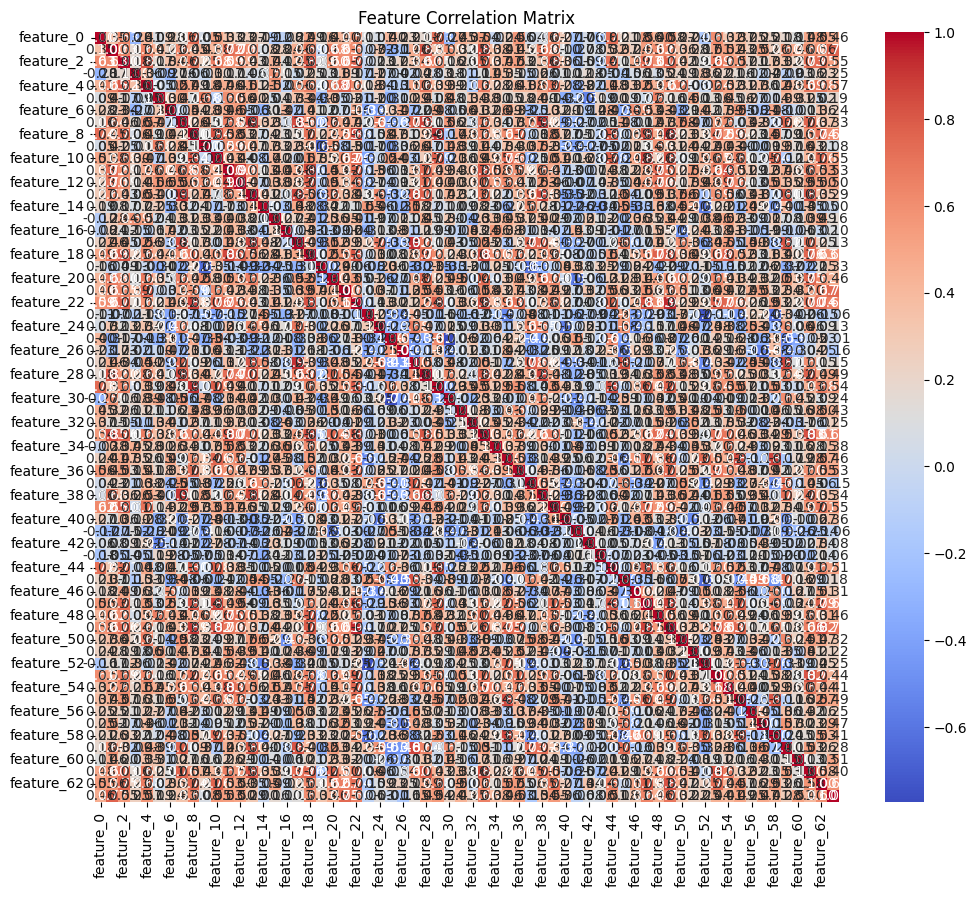

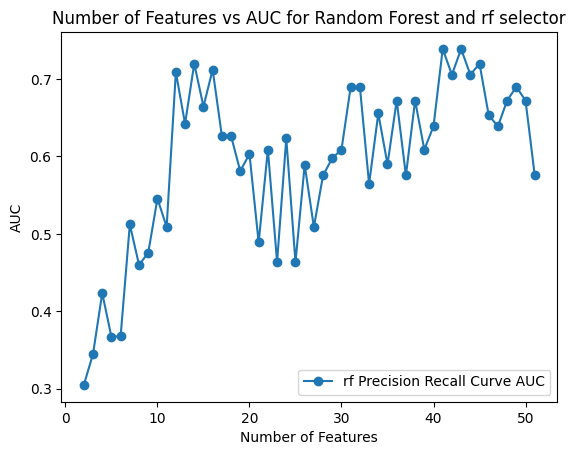

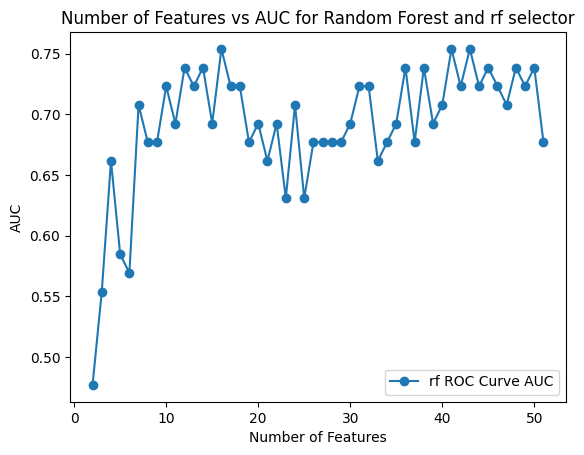

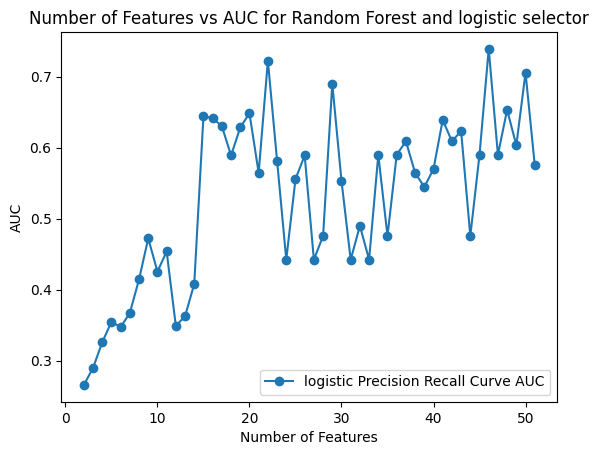

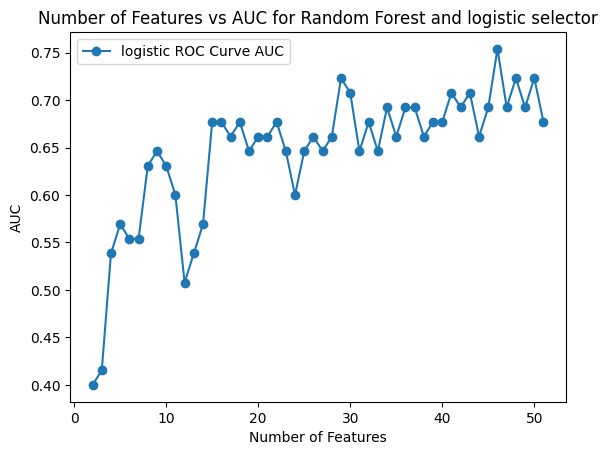

alpha is  0.001
Lasso selection [[0.49318686 0.18099336 0.162886   ... 0.51609486 0.2898079  0.23817776]
 [0.34408626 0.17963688 0.15131015 ... 0.6765474  0.21968514 0.1475502 ]
 [0.33666646 0.14883755 0.15908168 ... 0.7556213  0.2693963  0.11163124]
 ...
 [0.18014112 0.08296444 0.05257909 ... 0.40638593 0.3386496  0.03929724]
 [0.2510957  0.05349177 0.05642756 ... 0.31374964 0.36128783 0.043641  ]
 [0.35129812 0.05341211 0.0570318  ... 0.2978025  0.38067192 0.06771374]]
0.5333333333333333 0.4 0.8 [[7 6]
 [1 4]] 0.6111111111111112 [0.27777778 0.23529412 0.25       0.26666667 0.28571429 0.30769231
 0.33333333 0.36363636 0.4        0.44444444 0.5        0.42857143
 0.5        0.4        0.25       0.33333333 0.5        0.
 1.        ] [1.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.6 0.6 0.4 0.2 0.2 0.2 0.
 0. ] 0.4355555555555556 0.6307692307692309 0.49
alpha is  0.035448275862068966
Lasso selection []
Selezionate 0 features
alpha is  0.06989655172413793
Lasso selection []
Selezionate 0 

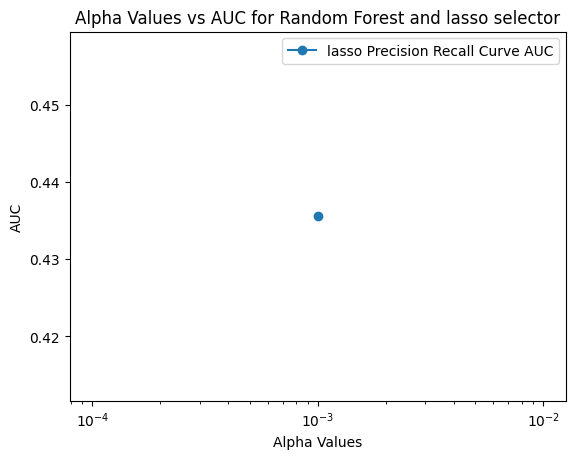

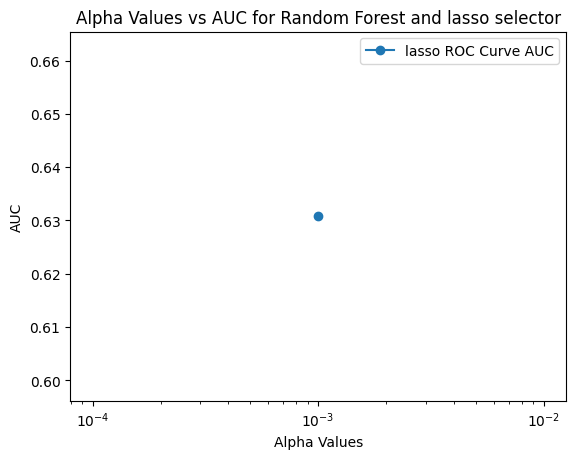

Starting with the 1 fold
[ 0  1  2  3  4  6  7  8 10 12 13 14 15 17 18 19 20 21 22 23 24 25 26 27
 29 32 33 36 37 38 41 43 46 47 48 49 50 51 52 53 55 56 57 58 59 60 61 62
 63 64 66 67 68 69 70 71 73 74 75 76 77 78 79 80 81 82 83 84 85]
[ 5  9 11 16 28 30 31 34 35 39 40 42 44 45 54 65 72]
y_train  [0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0
 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1]
y_val  [0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1]
(2189, 64)
Removed features: ['feature_13', 'feature_17', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_44']
['feature_13', 'feature_17', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_44']


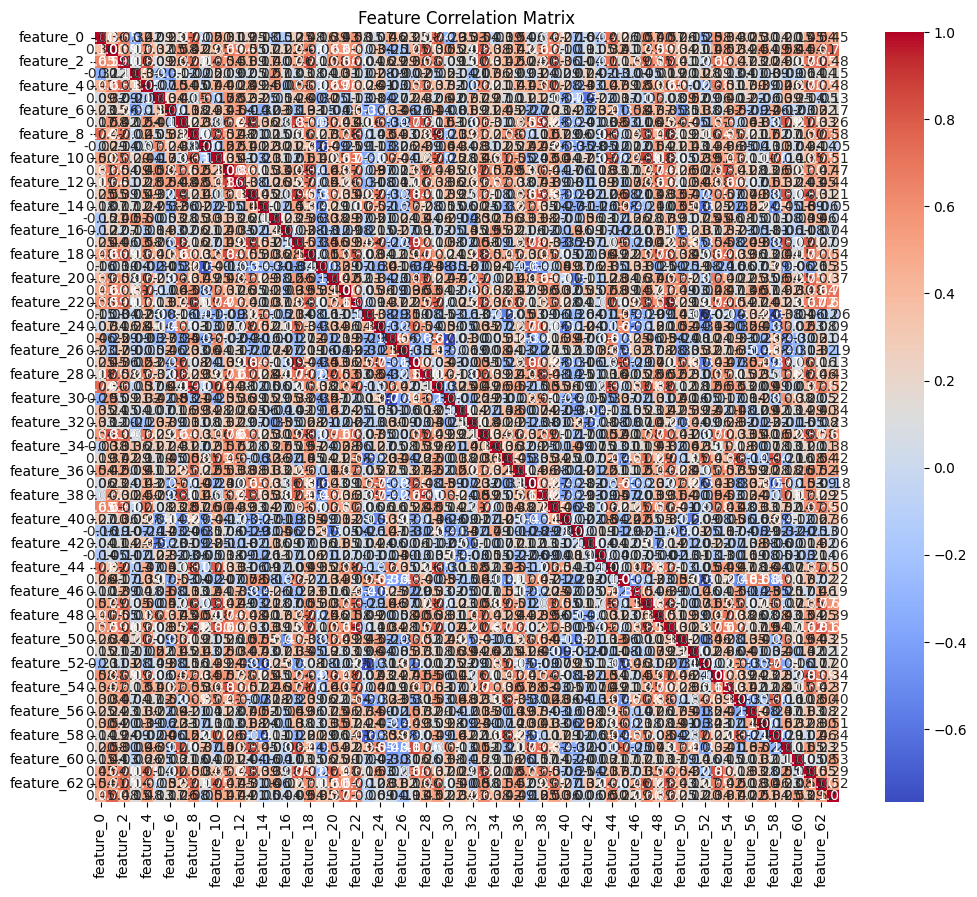

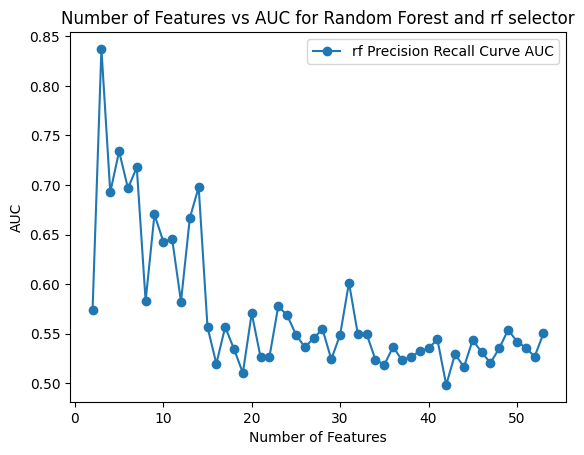

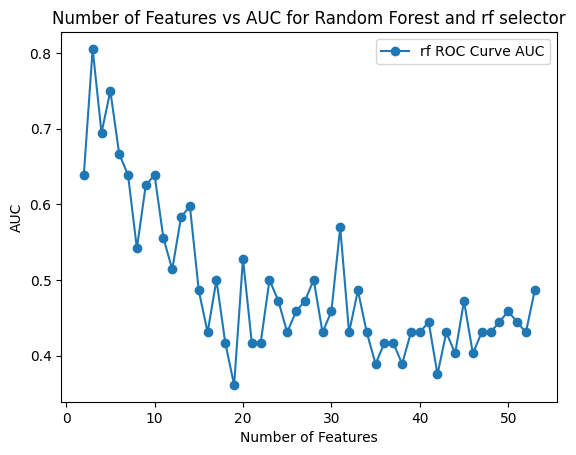

KeyboardInterrupt: 

In [65]:

for train_index, val_index in kf.split(len_train):
#for i in range (0,1):
    print(f"Starting with the {i} fold")
    ## creazione fold
    features_train = []
    features_val = []
    
    
    for idx in train_index:
        features=[]
        for x in range(len(features_train1[idx])):
            features.append(features_train1[idx][x])
        features=np.array(features)
        features_train.append(features)
        
    j=0
    for idx in val_index:
        features=[]
        for x in range(len(features_train1[idx])):
            features.append(features_train1[idx][x])
        features=np.array(features)
        features_val.append(features)

    y_train, y_val = y_train1[train_index], y_train1[val_index]
    patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]


    print("y_train ", y_train)
    print("y_val ", y_val)

    ## fine creazione fold



    features=perform_correlation(features_train, y_train, 64, 0.85)
    print(features)

    final_patients_train=remove_features_from_patients(features_train, features)
    #final_patients_test=remove_features_from_patients(features_test, features)
    final_patients_val=remove_features_from_patients(features_val, features)

    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)


    results_rf = {}

    for selector in selectors:

        results_rf[selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
        }

        if selector == 'lasso':
            for alpha in alpha_values:

                rf = RandomForestClassifier(n_estimators=100, random_state=42)
                print("alpha is ", alpha)
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, error = classification_method1(
                    selector, alpha, rf, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, 0
                )
                if(error==1):
                    continue
                print(best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt)
                results_rf[selector]['alpha'].append(alpha)
                results_rf[selector]['pr_auc'].append(pr_auc)
                results_rf[selector]['best_precision'].append(best_precision)
                results_rf[selector]['best_recall'].append(best_recall)
                results_rf[selector]['roc_auc'].append(roc_auc)
                results_rf[selector]['f1'].append(best_f1_score)
                results_rf[selector]['accuracy'].append(test_accuracy)
                results_rf[selector]['confusion_matrix'].append(conf)
                results_rf[selector]['best_threshold'].append(bt)
                

            # Plot dei risultati per 'lasso'
            plt.figure()
            plt.plot(results_rf[selector]['alpha'], results_rf[selector]['pr_auc'], marker='o', linestyle='-', label=f'{selector} Precision Recall Curve AUC')
            plt.xlabel('Alpha Values')
            plt.ylabel('AUC')
            plt.title(f'Alpha Values vs AUC for Random Forest and {selector} selector')
            plt.xscale('log')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(results_rf[selector]['alpha'], results_rf[selector]['roc_auc'], marker='o', linestyle='-', label=f'{selector} ROC Curve AUC')
            plt.xlabel('Alpha Values')
            plt.ylabel('AUC')
            plt.title(f'Alpha Values vs AUC for Random Forest and {selector} selector')
            plt.xscale('log')
            plt.legend()
            plt.show()

        else:
            for t in range(2, len(x_train_expanded[0])+1):

                rf = RandomForestClassifier(n_estimators=100, random_state=42)

                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, _ = classification_method1(
                    selector, 0, rf, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, t
                )
                results_rf[selector]['num_features'].append(t)
                results_rf[selector]['pr_auc'].append(pr_auc)
                results_rf[selector]['best_precision'].append(best_precision)
                results_rf[selector]['best_recall'].append(best_recall)
                results_rf[selector]['roc_auc'].append(roc_auc)
                results_rf[selector]['f1'].append(best_f1_score)
                results_rf[selector]['accuracy'].append(test_accuracy)
                results_rf[selector]['confusion_matrix'].append(conf)
                results_rf[selector]['best_threshold'].append(bt)
    i=i+1
        